In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import uproot

import histlite as hl

import scipy.interpolate as interp

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,5)


def Gaussian( x, A, mu, sig ):
    
    return A * np.exp(-(x-mu)**2/(2*sig**2))


# Gamma detector calibrations

Looking at the Ba133 calibration data taken when the cell was open. Run30139.



In [35]:
replayed_data_dir = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30139/'

rootfiles = [filename for filename in os.listdir(replayed_data_dir) \
                                         if filename.endswith('.root')]


In [36]:
data_list = []

for thisfile in rootfiles:
    print('Opening {}'.format(thisfile))
    
    fullpath = replayed_data_dir + thisfile
    
    data_list.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    


Opening run30139_11.root
Opening run30139_20.root
Opening run30139_4.root
Opening run30139_0.root
Opening run30139_15.root
Opening run30139_19.root
Opening run30139_8.root
Opening run30139_18.root
Opening run30139_9.root
Opening run30139_10.root
Opening run30139_21.root
Opening run30139_5.root
Opening run30139_1.root
Opening run30139_14.root
Opening run30139_12.root
Opening run30139_7.root
Opening run30139_3.root
Opening run30139_16.root
Opening run30139_13.root
Opening run30139_6.root
Opening run30139_22.root
Opening run30139_2.root
Opening run30139_17.root


In [37]:
data = pd.concat(data_list,ignore_index=True)

data.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,27.0,7.266667,0.0,3.600361e+10,4829.983467,8.0,0.0,4829.983467,85.0,99.0,116.0,484.0
1,27.0,240.525000,0.0,3.600365e+10,2185.013988,8.0,0.0,2185.013988,75.0,87.0,109.0,203.0
2,30.0,72.425000,0.0,3.600383e+10,5320.060045,8.0,0.0,5320.060045,105.0,117.0,241.0,463.0
3,30.0,1056.625000,0.0,3.600383e+10,8450.427691,8.0,0.0,8450.427691,91.0,105.0,126.0,232.0
4,30.0,68.533333,0.0,3.600385e+10,1809.376408,8.0,0.0,1809.376408,104.0,116.0,302.0,471.0


## First, look at PMT detector

In [89]:
mask_pmt = data['gamma_ch'] == 27

data_pmt = data.loc[mask_pmt]

data_pmt.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,27.0,7.266667,0.0,3.600361e+10,4829.983467,8.0,0.0,4829.983467,85.0,99.0,116.0,484.0
1,27.0,240.525000,0.0,3.600365e+10,2185.013988,8.0,0.0,2185.013988,75.0,87.0,109.0,203.0
5,27.0,258.866667,0.0,3.600394e+10,10171.279071,8.0,0.0,10171.279071,68.0,80.0,104.0,188.0
6,27.0,43.591667,0.0,3.600394e+10,627.709057,8.0,0.0,627.709057,77.0,87.0,102.0,164.0
7,27.0,314.275000,0.0,3.600398e+10,3535.976134,8.0,0.0,3535.976134,70.0,85.0,108.0,192.0


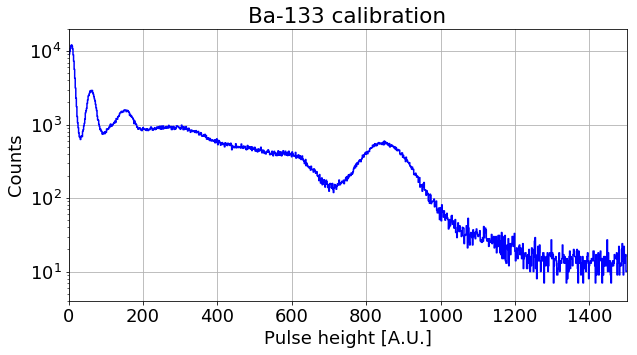

In [90]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,5)

h_pmt_energy = hl.hist( data_pmt['gamma_PH'], bins=np.linspace(0.,1500.,1000) )

hl.plot1d( h_pmt_energy, color='b', label='PMT detector' )
plt.yscale('log')

plt.xlim(0.,1500.)
plt.ylim(4.,2e4)

bincenters = (h_pmt_energy.bins[0][1:] + h_pmt_energy.bins[0][:-1])/2.
binvals = h_pmt_energy.values

plt.xlabel('Pulse height [A.U.]')
plt.ylabel('Counts')
plt.title('Ba-133 calibration')
plt.grid()

plt.savefig('Plots/pmt_ba133_calibration_no_fit.png',dpi=200,bbox_inches='tight')

In [91]:
def Gaussian( x, A, mu, sig ):
    
    return A * np.exp(-(x-mu)**2/(2*sig**2))



# Define the gamma data for Ba-133
br_356 = 0.6205
br_383 = 0.0894
br_81 = 0.329
br_79 = 0.0265
br_53 = 0.0214
br_35 = 0.0351
br_34 = 0.114 + 0.0588
br_31 = 0.622 + 0.339

e_383 = 383.8485 
e_356 = 356.0129
e_81 = 80.9979
e_79 = 79.6142
e_53 = 53.1622
e_35 = 35.818
e_34 = 34.95
e_31 = 30.8




def FitBa133_356keV( x, A, mu, sig ):
    # This function is intended to fit simultaneously the 356 and 383 keV
    # gamms in the Ba-133 spectrum. It relies on the assumption that, over this
    # short energy range, the response is linear and the resolution for both
    # peaks is the same.
    

    
    return A * (  Gaussian( x, br_356, mu, sig) + \
                    Gaussian( x, br_383, mu*(e_383/e_356), sig ) )




def FitBa133_81keV( x, A, mu, sig ):
    
    return A * ( Gaussian(x, br_81, mu, sig) + \
                    Gaussian( x, br_79, mu*(e_79/e_81), sig) + \
                    Gaussian( x, br_53, mu*(e_53/e_81), sig ) )
    
    

def FitBa133_31keV( x, A, mu, sig ):
    
    return A * ( Gaussian(x, br_31, mu, sig) + \
                    Gaussian( x, br_34, mu*(e_34/e_31), sig) + \
                    Gaussian( x, br_35, mu*(e_35/e_31), sig ) )
    
    
                  

    

In [92]:
# Fit the stuff at 356 keV
fitmask = (bincenters > 590.) & (bincenters <680.)

p356, cov356 = curve_fit( FitBa133_356keV, bincenters[fitmask], binvals[fitmask], \
                            p0=(900.,600.,50.))



# Fit the 80
fitmask = (bincenters > 120.) & (bincenters < 180.)
p81, cov81 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(1500.,150.,10.))



# Fit the 80
fitmask = (bincenters > 120.) & (bincenters < 180.)
p81, cov81 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(1500.,150.,10.))


# Fit the 31 keV
fitmask = (bincenters > 50.) & (bincenters < 80.)
p31, cov31 = curve_fit( FitBa133_31keV, bincenters[fitmask], binvals[fitmask], \
                             p0=(3000.,60.,10.))

# Fit the 500 keV
fitmask = (bincenters > 780.) & (bincenters < 900.)
p500, cov500 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(700.,850.,30.))

print(p500)

[558.38217115 845.89728316  59.18399539]


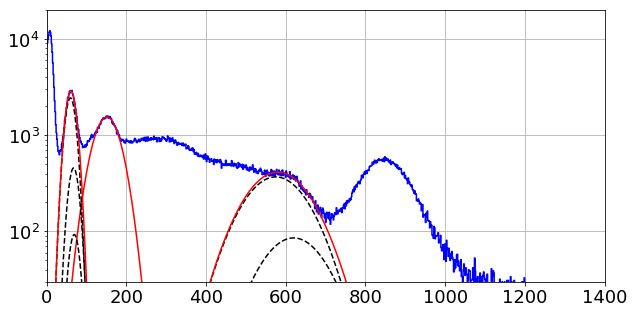

In [93]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,5)

hl.plot1d( h_pmt_energy, color='b', label='PMT detector' )
plt.yscale('log')

xfit = np.linspace(0.,1500.,1000)

# Plot the 356 keV stuff
plt.plot(xfit,Gaussian(xfit, p356[0] * br_356, p356[1], p356[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p356[0] * br_383/br_356, \
                               p356[1]*(e_383/e_356), p356[2] ),'--k')
yfit = FitBa133_356keV( xfit, p356[0], p356[1], p356[2] )
plt.plot(xfit,yfit,'-r')


# # Plot the 81 keV fit
plt.plot( xfit, Gaussian( xfit, p81[0], p81[1], p81[2]), '-r')


# Plot the 31 keV stuff
plt.plot(xfit,Gaussian(xfit, p31[0] * br_31, p31[1], p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_34/br_31, \
                               p31[1]*(e_34/e_31), p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_35/br_31, \
                               p31[1]*(e_35/e_31), p31[2] ),'--k')
yfit = FitBa133_31keV( xfit, p31[0], p31[1], p31[2] )
plt.plot(xfit,yfit,'-r')





plt.xlim(0.,1400.)
plt.ylim(30.,2e4)

plt.grid()

plt.savefig('Plots/pmt_ba133_calibration_with_fit.png',dpi=200,bbox_inches='tight')

(0.0, 700.0)

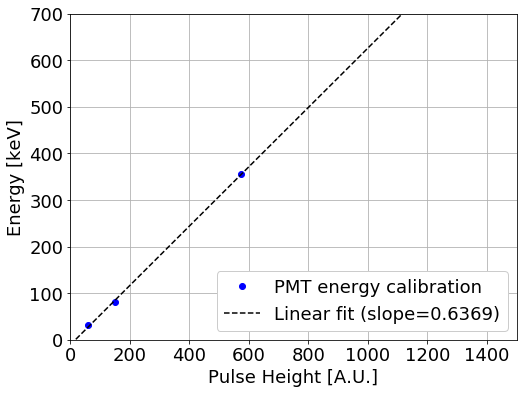

In [94]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

xvals = np.array( [ p31[1], p81[1], p356[1] ] )
energies = np.array( [ e_31, e_81, e_356 ] )

plt.plot(xvals,energies,'ob',label='PMT energy calibration')
plt.xlabel('Pulse Height [A.U.]')
plt.ylabel('Energy [keV]')

ecal_fit = np.polyfit(xvals,energies,1)

plt.plot(xfit,xfit * ecal_fit[0] + ecal_fit[1],'--k',\
         label='Linear fit (slope={:4.4})'.format(ecal_fit[0]))
plt.grid()
plt.legend(framealpha=1)
plt.xlim(0.,1500.)
plt.ylim(0.,700.)




In [95]:
(302-ecal_fit[1])/ecal_fit[0]

491.39503177857085

## Checking out pulse quality variables

In [96]:
data_pmt.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,27.0,7.266667,0.0,3.600361e+10,4829.983467,8.0,0.0,4829.983467,85.0,99.0,116.0,484.0
1,27.0,240.525000,0.0,3.600365e+10,2185.013988,8.0,0.0,2185.013988,75.0,87.0,109.0,203.0
5,27.0,258.866667,0.0,3.600394e+10,10171.279071,8.0,0.0,10171.279071,68.0,80.0,104.0,188.0
6,27.0,43.591667,0.0,3.600394e+10,627.709057,8.0,0.0,627.709057,77.0,87.0,102.0,164.0
7,27.0,314.275000,0.0,3.600398e+10,3535.976134,8.0,0.0,3535.976134,70.0,85.0,108.0,192.0


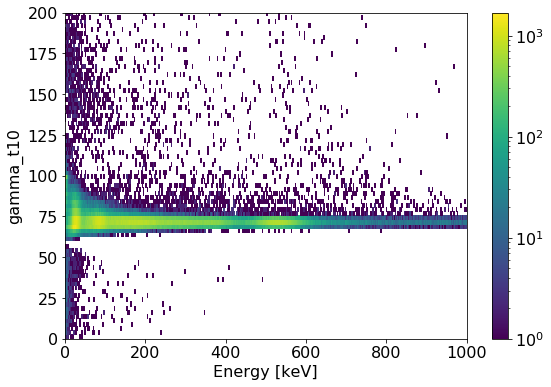

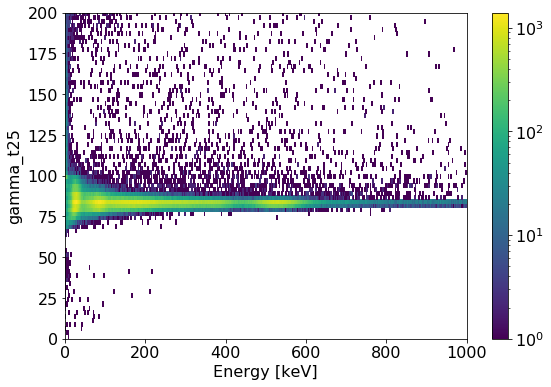

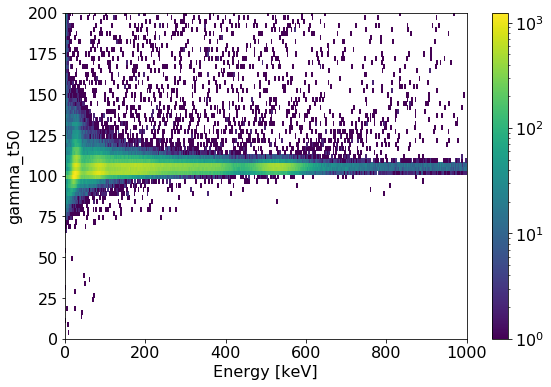

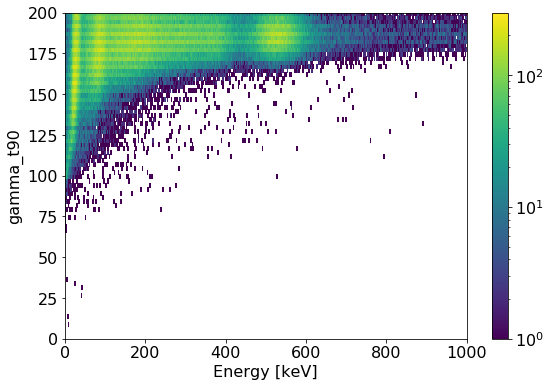

In [97]:
from matplotlib import colors

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (9,6)

quality_vars = ['gamma_t10', 'gamma_t25', 'gamma_t50', 'gamma_t90']

for i,var in enumerate(quality_vars):
    
    plt.figure(i)
    
#     plt.plot( data_pmt['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
#                 data_pmt[var], 'o', color = (0.,0.,1.,0.02), \
#                  markeredgecolor=(0.,0.,0.,0.), markersize=2, label=var)
    plt.hist2d( data_pmt['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
                 data_pmt[var], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel(var)
    plt.xlim(0.,1000.)
    plt.ylim(0.,200.)
    plt.colorbar()

    



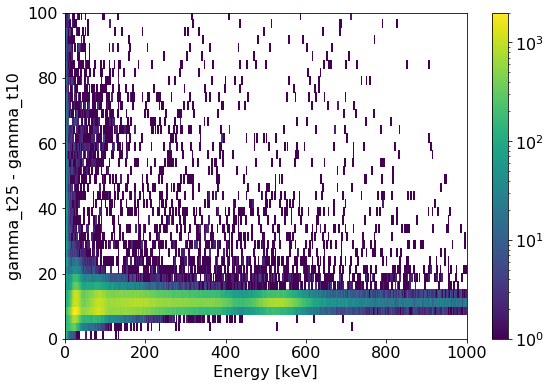

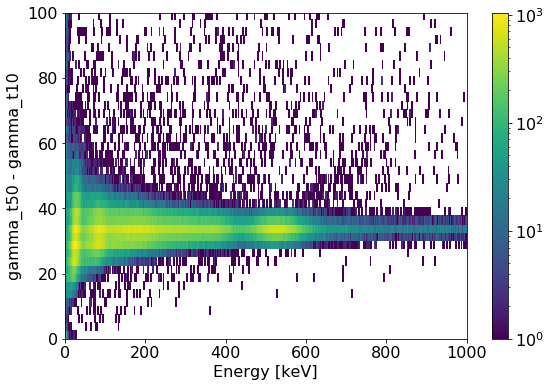

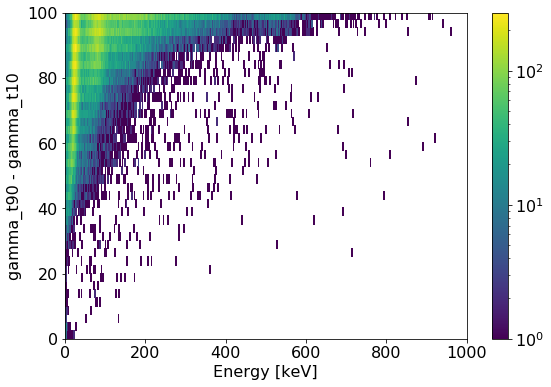

In [98]:
from matplotlib import colors

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (9,6)

quality_vars = ['gamma_t10', 'gamma_t25', 'gamma_t50', 'gamma_t90']

for i,var in enumerate(quality_vars):
    
    if 't10' in var: continue
    
    plt.figure(i)
    
#     plt.plot( data_pmt['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
#                 data_pmt[var], 'o', color = (0.,0.,1.,0.02), \
#                  markeredgecolor=(0.,0.,0.,0.), markersize=2, label=var)
    plt.hist2d( data_pmt['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
                 data_pmt[var] - data_pmt['gamma_t10'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel('{} - gamma_t10'.format(var))
    plt.xlim(0.,1000.)
    plt.ylim(0.,100.)
    plt.colorbar()

## PMT: Looking at waveforms

In [99]:
import pickle

datalist = []

for i in range(23):
    filename = replayed_data_dir + 'run30139_{}_nai_pmt_waveforms.pkl'.format(i)
    with open( filename ,'rb') as pklfile:
        datalist.extend(pickle.load(pklfile))
    
datadf = pd.DataFrame(datalist)



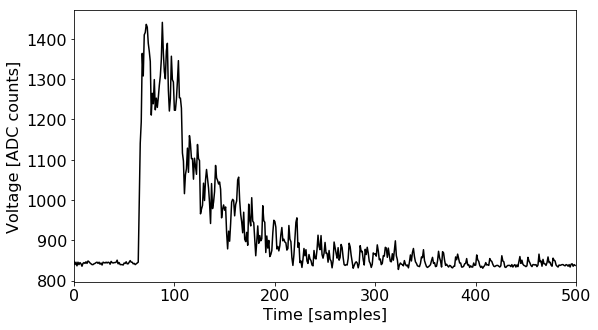

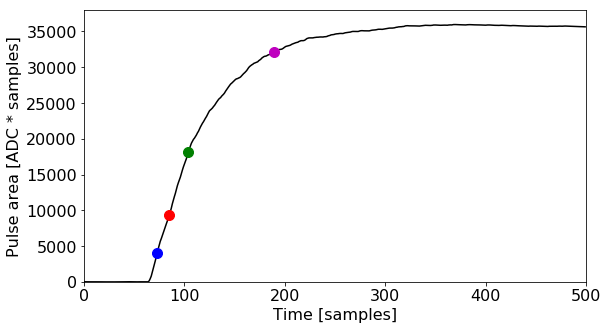

In [100]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (9,5)

plt.plot(datadf['samples'].iloc[0],'-k')
plt.xlabel('Time [samples]')
plt.ylabel('Voltage [ADC counts]')
plt.xlim(0.,500.)
plt.savefig('Plots/pmt_example_wfm.png',dpi=200,bbox_inches='tight')

plt.figure(2)

baseline = np.mean(datadf['samples'].iloc[0][:60])
area_curve = np.cumsum(datadf['samples'].iloc[0] - baseline)

t10 = np.where(area_curve > area_curve[-1]*0.1)[0][0]
t25 = np.where(area_curve > area_curve[-1]*0.25)[0][0]
t50 = np.where(area_curve > area_curve[-1]*0.5)[0][0]
t90 = np.where(area_curve > area_curve[-1]*0.9)[0][0]

plt.plot(area_curve,'-k')
plt.ylabel('Pulse area [ADC * samples]')
plt.xlabel('Time [samples]')
plt.plot(t10,area_curve[t10],'ob',markersize=10)
plt.plot(t25,area_curve[t25],'or',markersize=10)
plt.plot(t50,area_curve[t50],'og',markersize=10)
plt.plot(t90,area_curve[t90],'om',markersize=10)

plt.xlim(0.,500.)
plt.ylim(0.,38000.)
plt.savefig('Plots/pmt_example_area_fractional_times.png',dpi=200,bbox_inches='tight')

In [101]:
datadf.head()

,acc,channelid,formatbits,info,maw,mawtest,nsamplewords,peakhigh_index,peakhigh_reported,peakhigh_val,puflag,rindex,samples,t10,t25,t50,t90,timestamp
0,"[16863.0, 25298.0, 33746.0, 8423.0, 8435.0, 16...",11,5,0,"[14359.0, 7377.0, 6662.0]",0,250,88,891.183333,1441,0,567870,"[848.0, 840.0, 846.0, 837.0, 846.0, 840.0, 845...",73,85,104,189,125321539
1,"[16887.0, 25316.0, 33733.0, 8452.0, 8429.0, 16...",11,5,0,"[165.0, 90.0, 71.0]",0,250,88,7.391667,864,0,568133,"[849.0, 844.0, 846.0, 846.0, 846.0, 847.0, 843...",13,90,113,386,125371095
2,"[16857.0, 25296.0, 33721.0, 8423.0, 8439.0, 16...",11,5,0,"[153.0, 81.0, 74.0]",0,250,86,11.625000,884,0,568396,"[844.0, 840.0, 840.0, 846.0, 844.0, 837.0, 843...",86,105,215,460,125439387
3,"[16884.0, 25310.0, 33746.0, 8439.0, 8426.0, 16...",11,5,0,"[198.0, 115.0, 96.0]",0,250,167,295.575000,1150,0,568659,"[846.0, 846.0, 847.0, 845.0, 842.0, 837.0, 845...",74,86,113,208,125476413
4,"[16884.0, 25323.0, 33751.0, 8442.0, 8439.0, 16...",11,5,0,"[5073.0, 2540.0, 2258.0]",0,250,107,323.050000,1148,0,568922,"[845.0, 843.0, 843.0, 846.0, 846.0, 842.0, 842...",68,78,99,166,125514298


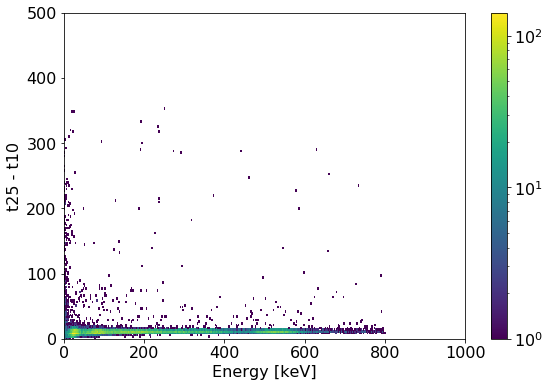

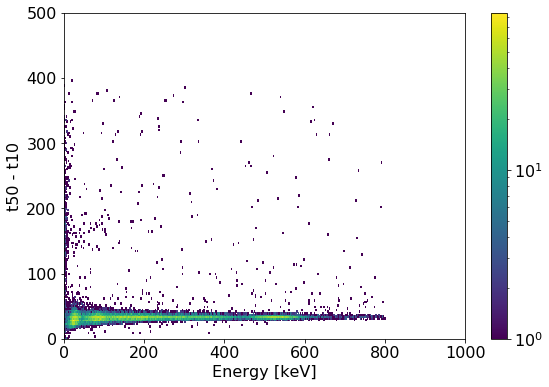

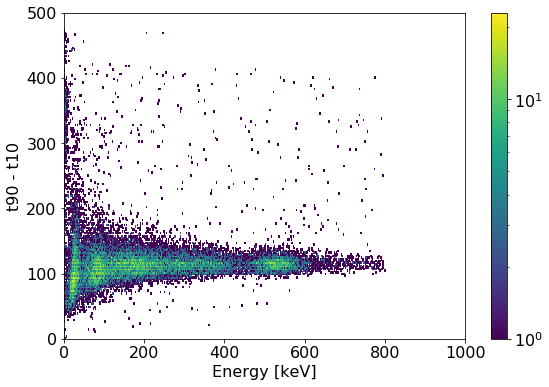

In [105]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (9,6)

quality_vars = ['t10', 't25', 't50', 't90']

for i,var in enumerate(quality_vars):
    
    if 't10' in var: continue
    
    plt.figure(i)
    
#     plt.plot( datadf['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
#                 datadf[var], 'o', color = (0.,0.,1.,0.02), \
#                  markeredgecolor=(0.,0.,0.,0.), markersize=2, label=var)
    plt.hist2d( datadf['peakhigh_reported'] * ecal_fit[0] + ecal_fit[1],\
                 datadf[var] - datadf['t10'], \
               bins=[np.linspace(0.,800.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel('{} - t10'.format(var))
    plt.xlim(0.,1000.)
    plt.colorbar()

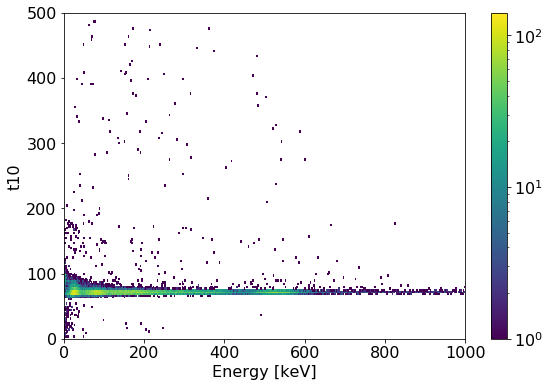

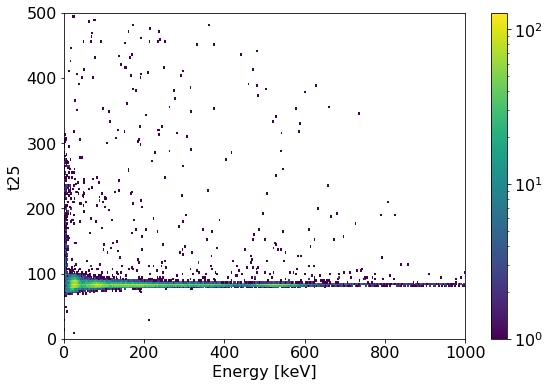

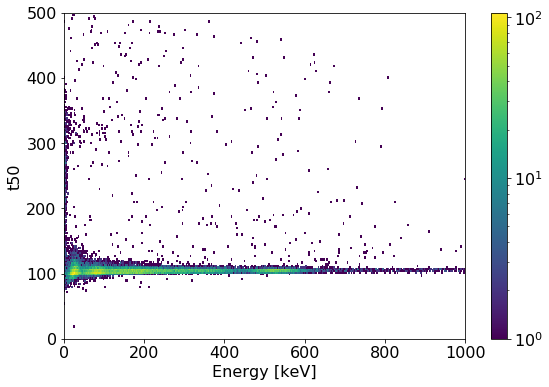

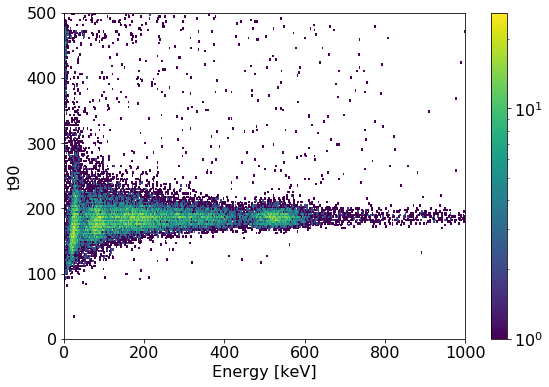

In [103]:
quality_vars = ['t10', 't25', 't50', 't90']

for i,var in enumerate(quality_vars):
    
    plt.figure(i)

    plt.hist2d( datadf['peakhigh_reported'] * ecal_fit[0] + ecal_fit[1],\
                 datadf[var], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel(var)
    plt.xlim(0.,1000.)
    plt.colorbar()


Text(0.5, 1.0, 'Pulse area < 25 & t50-10 <20')

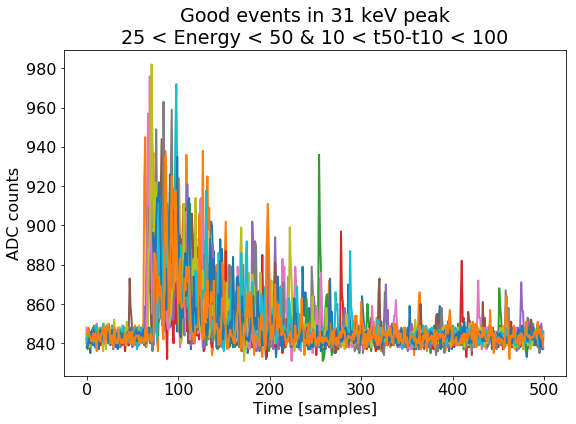

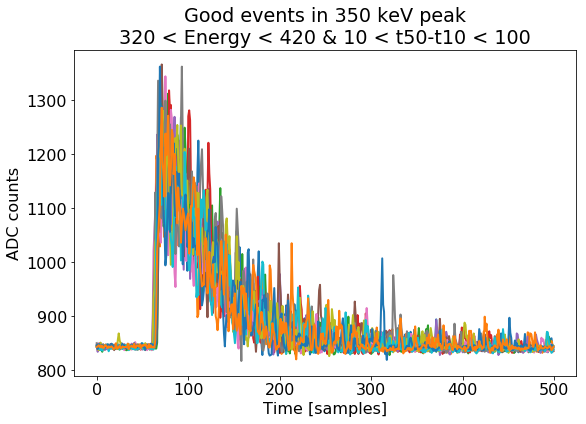

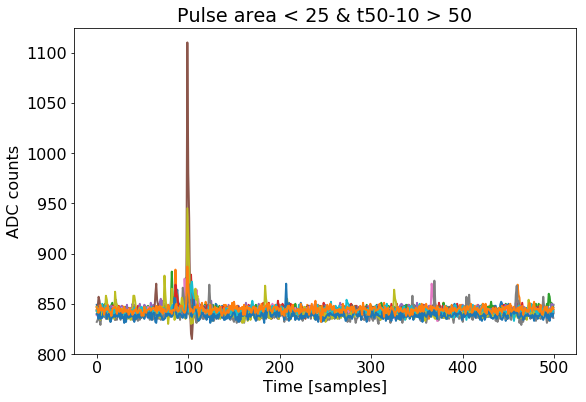

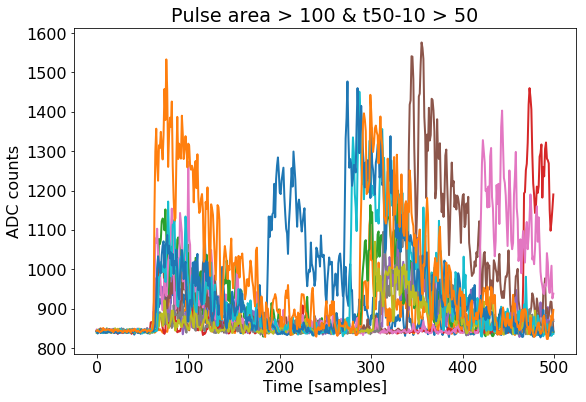

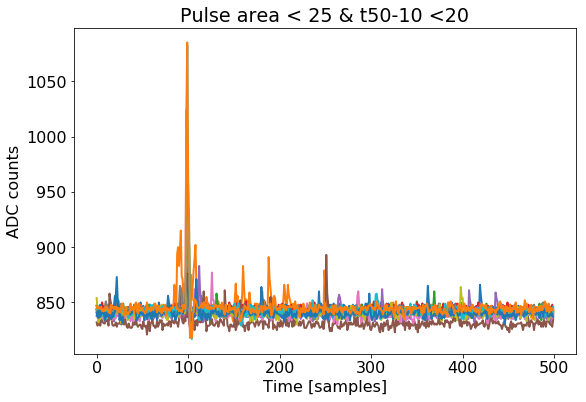

In [106]:
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']<100.)&\
        (datadf['t50']-datadf['t10']>10.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>25.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<50.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Good events in 31 keV peak\n25 < Energy < 50 & 10 < t50-t10 < 100')


plt.figure(2)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']<100.)&\
        (datadf['t50']-datadf['t10']>10.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>320.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<420.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Good events in 350 keV peak\n320 < Energy < 420 & 10 < t50-t10 < 100')





plt.figure(3)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']>50.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<25.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Pulse area < 25 & t50-10 > 50')


plt.figure(4)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']>100.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>100.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Pulse area > 100 & t50-10 > 50')


plt.figure(5)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']<20.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<25.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Pulse area < 25 & t50-10 <20')


# Charaterize the SiPM detector

In [51]:
mask_sipm = data['gamma_ch'] == 30

data_sipm = data.loc[mask_sipm]

data_sipm.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
2,30.0,72.425000,0.0,3.600383e+10,5320.060045,8.0,0.0,5320.060045,105.0,117.0,241.0,463.0
3,30.0,1056.625000,0.0,3.600383e+10,8450.427691,8.0,0.0,8450.427691,91.0,105.0,126.0,232.0
4,30.0,68.533333,0.0,3.600385e+10,1809.376408,8.0,0.0,1809.376408,104.0,116.0,302.0,471.0
9,30.0,719.350000,0.0,3.600418e+10,5716.143439,8.0,0.0,5716.143439,92.0,106.0,127.0,248.0
10,30.0,2837.116667,0.0,3.600421e+10,8948.584802,8.0,0.0,8948.584802,91.0,105.0,126.0,247.0


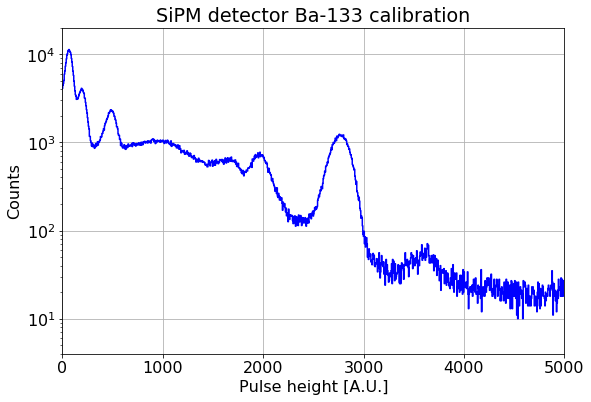

In [54]:
h_sipm_energy = hl.hist( data_sipm['gamma_PH'], bins=np.linspace(0.,5000.,1000) )

hl.plot1d( h_sipm_energy, color='b', label='sipm detector' )
plt.yscale('log')

plt.xlim(0.,5000.)
plt.ylim(4.,2e4)

bincenters = (h_sipm_energy.bins[0][1:] + h_sipm_energy.bins[0][:-1])/2.
binvals = h_sipm_energy.values

plt.xlabel('Pulse height [A.U.]')
plt.ylabel('Counts')
plt.title('SiPM detector Ba-133 calibration')
plt.grid()

In [55]:
# Fit the stuff at 356 keV
#fitmask = (bincenters > 2700.) & (bincenters < 3000.)
fitmask = (bincenters > 1800.) & (bincenters < 2100.)

p356, cov356 = curve_fit( FitBa133_356keV, bincenters[fitmask], binvals[fitmask], \
                            p0=(1000.,2000.,50.))



# Fit the 80
fitmask = (bincenters > 450.) & (bincenters < 580.)
p81, cov81 = curve_fit( Gaussian, bincenters[fitmask], binvals[fitmask], \
                             p0=(3000.,500.,40.))



# Fit the 31 keV
fitmask = (bincenters > 150.) & (bincenters < 250.)
p31, cov31 = curve_fit( FitBa133_31keV, bincenters[fitmask], binvals[fitmask], \
                             p0=(6000.,200.,10.))



[1060.98261722 1939.63943008  121.57210274]


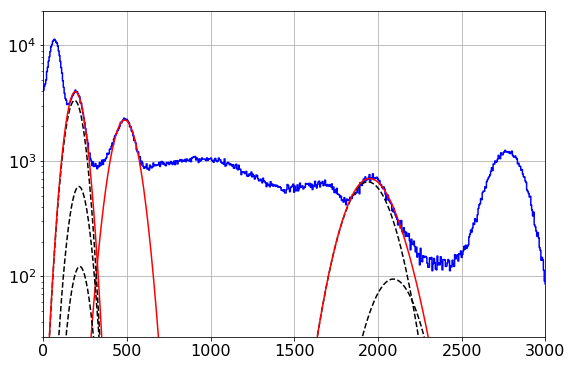

In [56]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (9,6)


hl.plot1d( h_sipm_energy, color='b', label='PMT detector' )
plt.yscale('log')

xfit = np.linspace(0.,5000.,1000)

# Plot the 356 keV stuff
plt.plot(xfit,Gaussian(xfit, p356[0] * br_356, p356[1], p356[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p356[0] * br_383, \
                               p356[1]*(e_383/e_356), p356[2] ),'--k')
yfit = FitBa133_356keV( xfit, p356[0], p356[1], p356[2] )
plt.plot(xfit,yfit,'-r')
print(p356)


# # Plot the 81 keV fit
plt.plot( xfit, Gaussian( xfit, p81[0], p81[1], p81[2]), '-r')


# Plot the 31 keV stuff
plt.plot(xfit,Gaussian(xfit, p31[0] * br_31, p31[1], p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_34, \
                               p31[1]*(e_34/e_31), p31[2] ),'--k')
plt.plot(xfit,Gaussian(xfit, p31[0] * br_35, \
                               p31[1]*(e_35/e_31), p31[2] ),'--k')
yfit = FitBa133_31keV( xfit, p31[0], p31[1], p31[2] )
plt.plot(xfit,yfit,'-r')





plt.xlim(0.,3000.)
plt.ylim(30.,2e4)

plt.grid()

plt.savefig('Plots/sipm_ba133_calibration_with_fit.png',dpi=200,bbox_inches='tight')

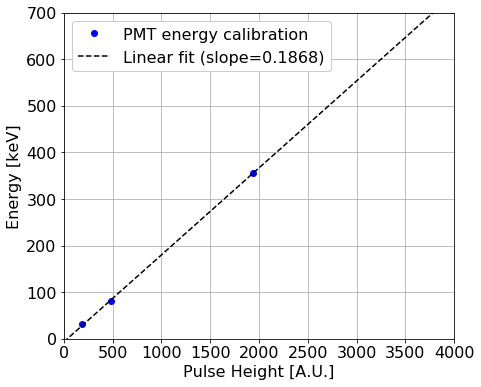

In [60]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (7,6)

xvals = np.array( [ p31[1], p81[1], p356[1] ] )
energies = np.array( [ e_31, e_81, e_356 ] )

plt.plot(xvals,energies,'ob',label='PMT energy calibration')
plt.xlabel('Pulse Height [A.U.]')
plt.ylabel('Energy [keV]')

ecal_fit = np.polyfit(xvals,energies,1)

plt.plot(xfit,xfit * ecal_fit[0] + ecal_fit[1],'--k',\
         label='Linear fit (slope={:4.4})'.format(ecal_fit[0]))
plt.grid()
plt.legend(framealpha=1)
plt.xlim(0.,4000.)
plt.ylim(0.,700.)

plt.savefig('Plots/sipm_ba133_linear_fit_calibration_curve.png',
            dpi=200,bbox_inches='tight')


In [103]:
1700* ecal_fit[0] + ecal_fit[1]

310.70908051948464

In [104]:
(302-ecal_fit[1])/ecal_fit[0]

1653.383263473149

In [105]:
## SiPM: Looking at pulse shape vars

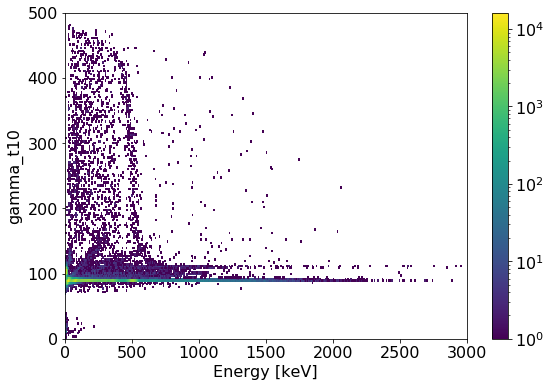

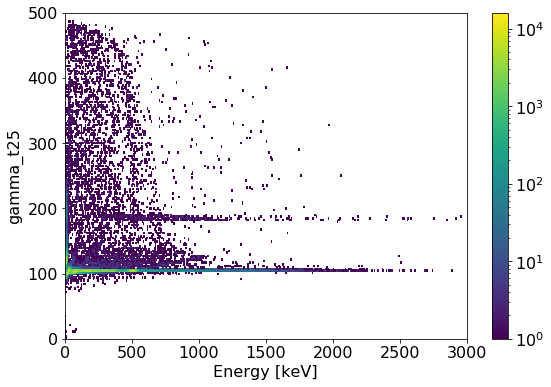

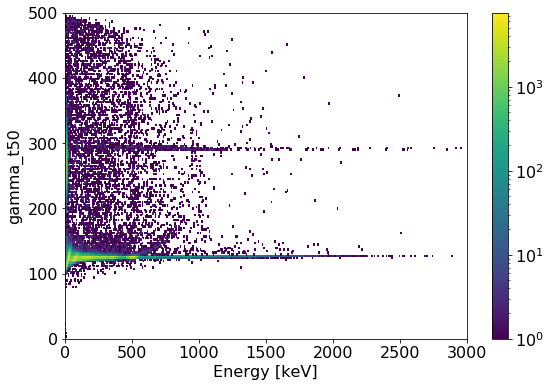

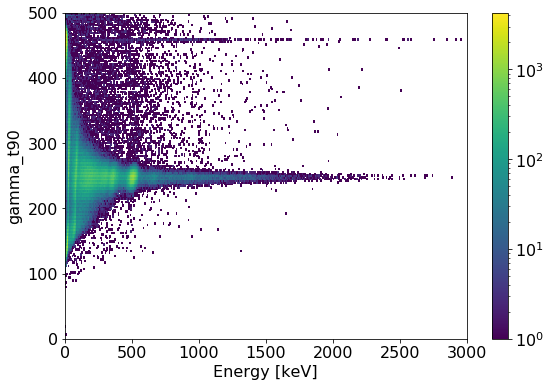

In [106]:
quality_vars = ['gamma_t10', 'gamma_t25', 'gamma_t50', 'gamma_t90']

for i,var in enumerate(quality_vars):
    
    plt.figure(i)
    
#     plt.plot( data_sipm['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
#                 data_sipm[var], 'o', color = (0.,0.,1.,0.02), \
#                  markeredgecolor=(0.,0.,0.,0.), markersize=2, label=var)
    plt.hist2d( data_sipm['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
                 data_sipm[var], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel(var)
    plt.xlim(0.,1000.)
    plt.colorbar()


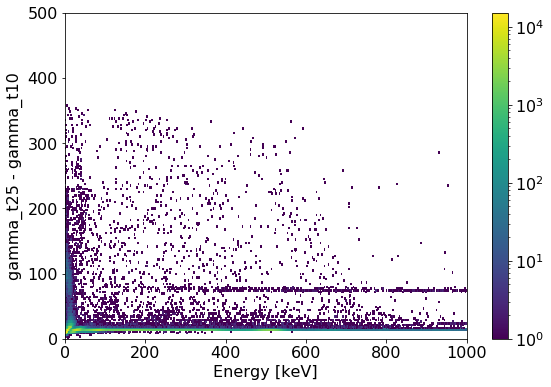

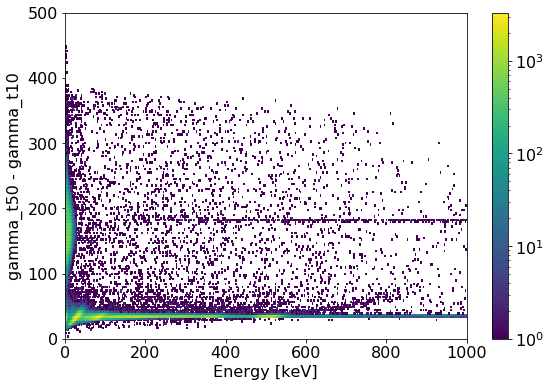

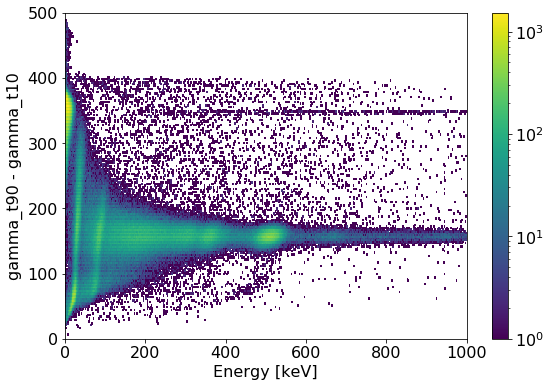

In [112]:
for i,var in enumerate(quality_vars):
    
    if 't10' in var: continue
    
    plt.figure(i)
    
#     plt.plot( data_sipm['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
#                 data_sipm[var], 'o', color = (0.,0.,1.,0.02), \
#                  markeredgecolor=(0.,0.,0.,0.), markersize=2, label=var)
    plt.hist2d( data_sipm['gamma_PH'] * ecal_fit[0] + ecal_fit[1],\
                 data_sipm[var] - data_sipm['gamma_t10'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel('{} - gamma_t10'.format(var))
    plt.xlim(0.,1000.)
    #plt.ylim(170,200)
    plt.colorbar()

# SiPM: looking at waveforms

In [109]:
datalist = []

for i in range(23):
    filename = replayed_data_dir + 'run30139_{}_nai_sipm_waveforms.pkl'.format(i)
    with open( filename ,'rb') as pklfile:
        datalist.extend(pickle.load(pklfile))
    
datadf = pd.DataFrame(datalist)



Text(0.5, 1.0, '180 < Energy < 185 & t50-10 > 200')

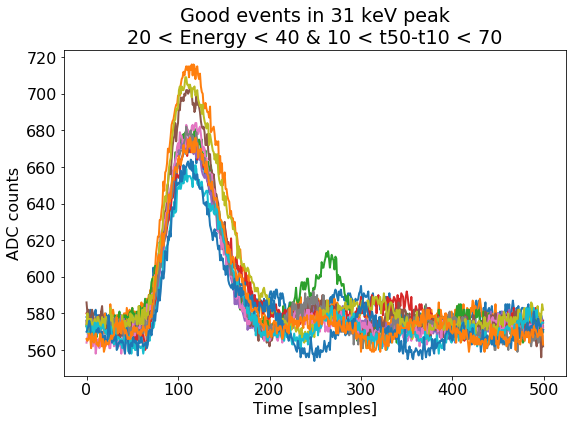

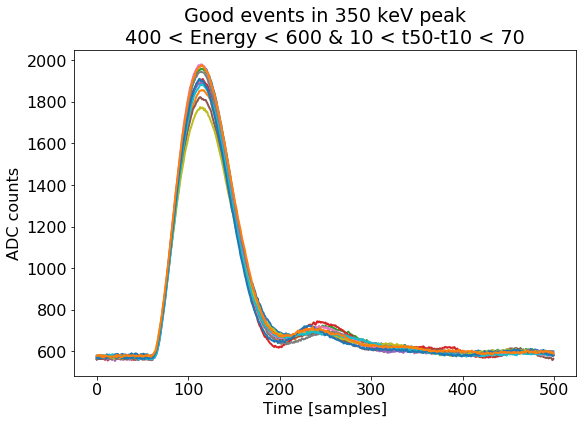

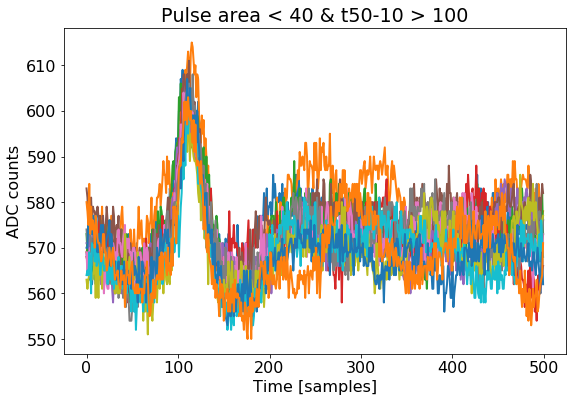

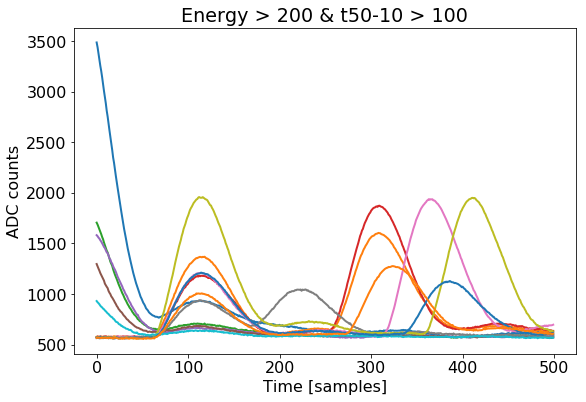

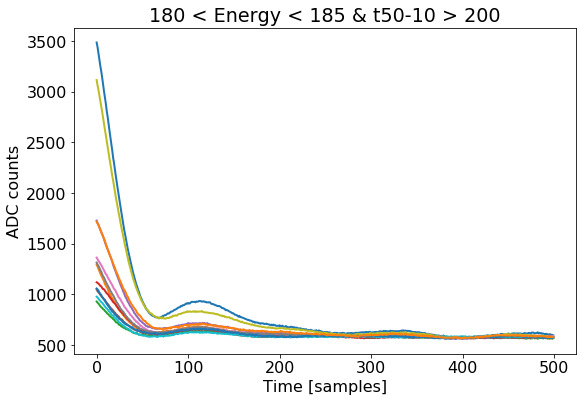

In [114]:
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']<70.)&\
        (datadf['t50']-datadf['t10']>10.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>20.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<40.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Good events in 31 keV peak\n20 < Energy < 40 & 10 < t50-t10 < 70')


plt.figure(2)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']<70.)&\
        (datadf['t50']-datadf['t10']>10.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>400.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<600.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Good events in 350 keV peak\n400 < Energy < 600 & 10 < t50-t10 < 70')





plt.figure(3)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']>100.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<40.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Pulse area < 40 & t50-10 > 100')


plt.figure(4)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']>100.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>200.)

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('Energy > 200 & t50-10 > 100')


plt.figure(5)
# Check out events with t50-t10 > 50 and pulse area < 25
mask = (datadf['t50']-datadf['t10']>180.)&\
        (datadf['t50']-datadf['t10']<185.)&\
        (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]>200.)
        

i=0
for index,row in datadf.loc[mask].iterrows():
    plt.plot(row['samples'], linewidth=2)
    
    if i > 10: break
    i += 1
    
plt.xlabel('Time [samples]')
plt.ylabel('ADC counts')
plt.title('180 < Energy < 185 & t50-10 > 200')


# plt.figure(6)
# # Check out events with t50-t10 > 50 and pulse area < 25
# mask = (datadf['t50']-datadf['t10']<20.)&\
#         (datadf['peakhigh_reported']* ecal_fit[0] + ecal_fit[1]<25.)

# i=0
# for index,row in datadf.loc[mask].iterrows():
#     plt.plot(row['samples'], linewidth=2)
    
#     if i > 10: break
#     i += 1
    
# plt.xlabel('Time [samples]')
# plt.ylabel('ADC counts')
# plt.title('Pulse area < 25 & t50-10 <20')


# Cross-check with Cs137 data

In [17]:
cs_replayed_data_dir = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30144/'

rootfiles = [filename for filename in os.listdir(cs_replayed_data_dir) \
                                         if filename.endswith('.root')]


In [18]:
data_list = []

for thisfile in rootfiles:
    print('Opening {}'.format(thisfile))
    
    fullpath = cs_replayed_data_dir + thisfile
    
    data_list.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], \
                                                    outputtype=pd.DataFrame ) )
    

Opening run30144_2.root
Opening run30144_3.root
Opening run30144_1.root
Opening run30144_4.root
Opening run30144_0.root


In [19]:
data = pd.concat(data_list,ignore_index=True)

mask_pmt = data['gamma_ch'] == 27

data_pmt = data.loc[mask_pmt]

data_pmt.head()

,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
1,27.0,1133.891667,0.0,1.279918e+10,8153.154729,8.0,0.0,8153.154729,73.0,85.0,107.0,190.0
2,27.0,85.733333,0.0,1.279918e+10,12308.112098,8.0,0.0,12308.112098,71.0,83.0,102.0,173.0
4,27.0,741.100000,0.0,1.279923e+10,3886.037452,8.0,0.0,3886.037452,73.0,84.0,105.0,187.0
11,27.0,279.075000,0.0,1.279946e+10,9070.767246,8.0,0.0,9070.767246,73.0,83.0,107.0,187.0
13,27.0,1089.933333,0.0,1.279947e+10,5116.304938,8.0,0.0,5116.304938,74.0,84.0,105.0,192.0


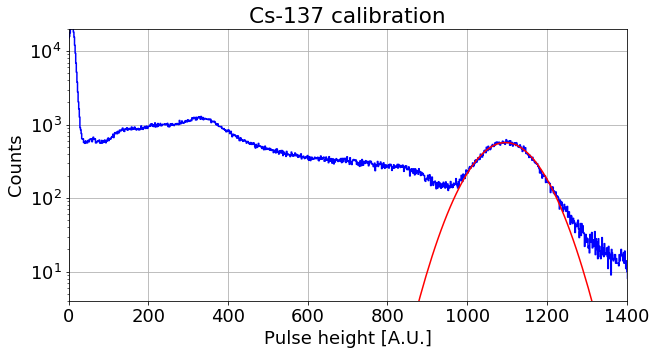

In [24]:
h_pmt_energy = hl.hist( data_pmt['gamma_PH'], bins=np.linspace(0.,1500.,1000) )

hl.plot1d( h_pmt_energy, color='b', label='PMT detector' )
plt.yscale('log')

plt.xlim(0.,1400.)
plt.ylim(4.,2e4)

bincenters = (h_pmt_energy.bins[0][1:] + h_pmt_energy.bins[0][:-1])/2.
binvals = h_pmt_energy.values

plt.xlabel('Pulse height [A.U.]')
plt.ylabel('Counts')
plt.title('Cs-137 calibration')
plt.grid()


fitmask = (bincenters>1000.)&(bincenters<2000.)

pcs,covcs = curve_fit(Gaussian,\
                      bincenters[fitmask],\
                      binvals[fitmask],\
                      p0=(800.,1100.,50.))

xfit = np.linspace(0.,1500.,200)
yfit = Gaussian( xfit, pcs[0], pcs[1], pcs[2])
plt.plot(xfit,yfit,'-r')             

plt.savefig('Plots/pmt_cs137_calibration_with_fit.png',dpi=200,bbox_inches='tight')
                      
                      

[ 0.61363053 -6.26579235]
512.2520065941601


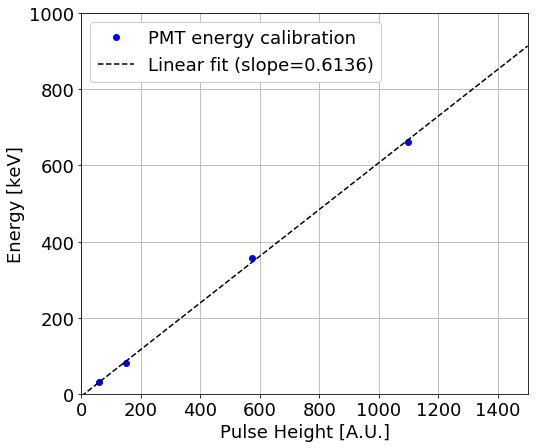

In [50]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,7)

xvals = np.array( [ p31[1], p81[1], p356[1], pcs[1] ] )
energies = np.array( [ e_31, e_81, e_356, 662.1] )

plt.plot(xvals,energies,'ob',label='PMT energy calibration')
plt.xlabel('Pulse Height [A.U.]')
plt.ylabel('Energy [keV]')

ecal_fit = np.polyfit(xvals,energies,1)

plt.plot(xfit,xfit * ecal_fit[0] + ecal_fit[1],'--k',\
         label='Linear fit (slope={:4.4})'.format(ecal_fit[0]))
plt.grid()
plt.legend(framealpha=1)
plt.xlim(0.,1500.)
plt.ylim(0.,1000.)

plt.savefig('Plots/pmt_ba133_and_cs137_linear_fit_calibration_curve.png',\
            dpi=200,bbox_inches='tight')

print(ecal_fit)
print(ecal_fit[0] * 845 + ecal_fit[1])


